# Reinforcement Learning: Assignment 1 



## Part 1: Stationary k-Armed Bandit


# Reinforcement Learning: Assignment 1 (Part 1)

This notebook implements and analyzes four bandit algorithms on a stationary 10-armed testbed according to the assignment:
1. Greedy with non-optimistic initial values (0)
2. Epsilon-greedy (tuned via pilot runs)
3. Greedy with optimistic initial values
4. Gradient bandit algorithm (tuned via pilot runs)

We run each method for 2000 time steps over 1000 simulations, reporting:
- Average per-step reward (averaged over simulations)
- Percentage of time the optimal action is selected at each time step




In [1]:

import numpy as np
import matplotlib.pyplot as plt



In [2]:
class KArmedBandit:
    """Stationary k-armed bandit with known true means."""
    def __init__(self, true_means):
        self.true_means = np.array(true_means)
        self.k = len(true_means)
    def pull(self, action):
        # Return reward sampled from N(mu[action], 1)
        return np.random.randn() + self.true_means[action]
    def optimal_actions(self):
        max_mu = np.max(self.true_means)
        return np.where(self.true_means == max_mu)[0]


In [3]:
class BanditAgent:
    def __init__(self, k):
        self.k = k
        self.reset()
    def reset(self): raise NotImplementedError
    def select_action(self): raise NotImplementedError
    def update(self, action, reward): raise NotImplementedError


In [4]:
class GreedyZeroAgent(BanditAgent):
    def __init__(self, k): super().__init__(k)
    def reset(self):
        self.Q = np.zeros(self.k)
        self.N = np.zeros(self.k, dtype=int)
    def select_action(self):
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

class EpsilonGreedyAgent(BanditAgent):
    def __init__(self, k, epsilon):
        self.epsilon = epsilon
        super().__init__(k)
    def reset(self):
        self.Q = np.zeros(self.k)
        self.N = np.zeros(self.k, dtype=int)
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

class GreedyOptimisticAgent(BanditAgent):
    def __init__(self, k, optimistic_value):
        self.optimistic_value = optimistic_value
        super().__init__(k)
    def reset(self):
        self.Q = np.full(self.k, self.optimistic_value, dtype=float)
        self.N = np.zeros(self.k, dtype=int)
    def select_action(self):
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

class GradientBanditAgent(BanditAgent):
    def __init__(self, k, alpha):
        self.alpha = alpha
        super().__init__(k)
    def reset(self):
        self.H = np.zeros(self.k)
        self.pi = np.full(self.k, 1/self.k)
        self.avg_reward = 0
        self.t = 0
    def select_action(self):
        exp_H = np.exp(self.H - np.max(self.H))
        self.pi = exp_H / np.sum(exp_H)
        return np.random.choice(self.k, p=self.pi)
    def update(self, action, reward):
        self.t += 1
        self.avg_reward += (reward - self.avg_reward) / self.t
        for a in range(self.k):
            if a == action:
                self.H[a] += self.alpha * (reward - self.avg_reward) * (1 - self.pi[a])
            else:
                self.H[a] -= self.alpha * (reward - self.avg_reward) * self.pi[a]


In [5]:
def run_simulation(agent_class, agent_params, k, time_steps, n_sims, seed_offset=0):
    rewards = np.zeros((n_sims, time_steps))
    optimal = np.zeros((n_sims, time_steps))
    for sim in range(n_sims):
        np.random.seed(sim + seed_offset)
        true_means = np.random.randn(k)
        env = KArmedBandit(true_means)
        optimal_actions = env.optimal_actions()
        if agent_class is GreedyOptimisticAgent:
            optimistic_value = np.max(true_means) + 2.575
            agent = agent_class(k, optimistic_value)
        else:
            agent = agent_class(k, *agent_params) if agent_params else agent_class(k)
        agent.reset()
        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)
            rewards[sim, t] = reward
            optimal[sim, t] = 1 if action in optimal_actions else 0
    avg_reward = rewards.mean(axis=0)
    pct_optimal = optimal.mean(axis=0) * 100
    return avg_reward, pct_optimal


In [6]:
# Pilot runs to choose epsilon and alpha (short runs)
k = 10
pilot_time_steps = 500
pilot_sims = 200
# Tune epsilon
epsilons = [0.01, 0.05, 0.1, 0.2]
epsilon_results = {}
for eps in epsilons:
    avg_reward, _ = run_simulation(EpsilonGreedyAgent, (eps,), k, pilot_time_steps, pilot_sims)
    epsilon_results[eps] = avg_reward[-1]
best_epsilon = max(epsilon_results, key=epsilon_results.get)
print('Pilot best epsilon:', best_epsilon)
# Tune alpha
alphas = [0.1, 0.2, 0.5]
alpha_results = {}
for alpha in alphas:
    avg_reward, _ = run_simulation(GradientBanditAgent, (alpha,), k, pilot_time_steps, pilot_sims)
    alpha_results[alpha] = avg_reward[-1]
best_alpha = max(alpha_results, key=alpha_results.get)
print('Pilot best alpha:', best_alpha)


Pilot best epsilon: 0.05
Pilot best alpha: 0.2


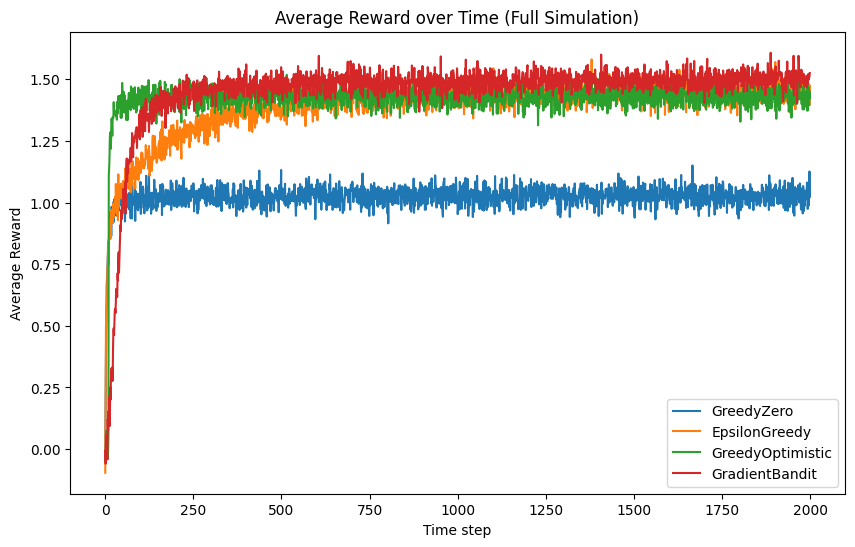

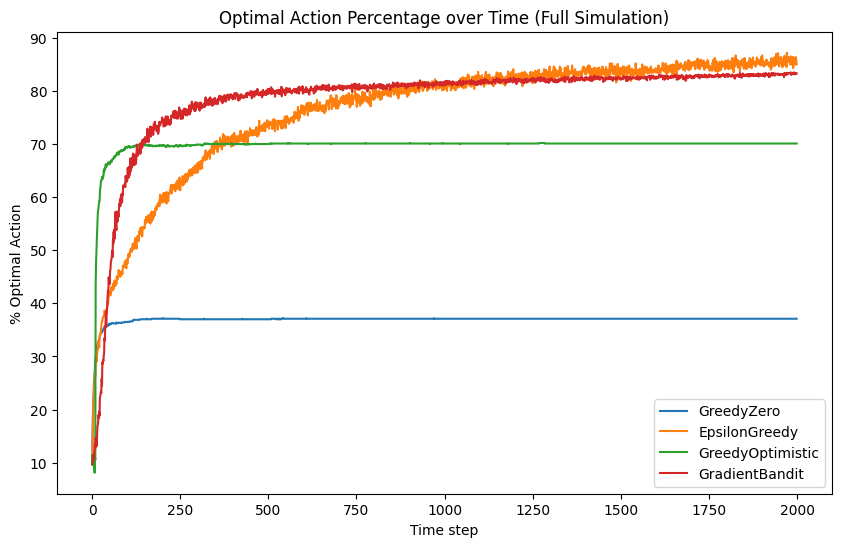

In [ ]:
## Full Simulation (2000 steps, 1000 simulations)

k = 10
time_steps = 2000
n_sims = 1000
# After pilot tuning, use best_epsilon and best_alpha
agents_info = [
    ('GreedyZero', GreedyZeroAgent, ()),
    ('EpsilonGreedy', EpsilonGreedyAgent, (best_epsilon,)),
    ('GreedyOptimistic', GreedyOptimisticAgent, ()),
    ('GradientBandit', GradientBanditAgent, (best_alpha,))
]
results = {}
for name, cls, params in agents_info:
    avg_reward, pct_optimal = run_simulation(cls, params if cls is not GreedyOptimisticAgent else (), k, time_steps, n_sims)
    results[name] = (avg_reward, pct_optimal)
# Plotting
plt.figure(figsize=(10, 6))
for name, (avg_reward, _) in results.items(): plt.plot(avg_reward, label=name)
plt.xlabel('Time step'); plt.ylabel('Average Reward'); plt.title('Simulation of Average Reward over Time'); plt.legend(); plt.show()
plt.figure(figsize=(10, 6))
for name, (_, pct_optimal) in results.items(): plt.plot(pct_optimal, label=name)
plt.xlabel('Time step'); plt.ylabel('% Optimal Action'); plt.title('Simulation of Optimal Action Percentage over Time'); plt.legend(); plt.show()



## Part 2: Non-Stationary k-Armed Bandit


# Reinforcement Learning: Assignment 1 (Part 2)

This notebook handles non-stationary k-armed bandit scenarios as specified:
1. Gradual changes:
   - Drift: μ_{i,t} = μ_{i,t-1} + ε_{i,t}, ε ~ N(0, 0.012)
   - Mean-reverting: μ_{i,t} = κ μ_{i,t-1} + ε_{i,t}, κ=0.5, ε ~ N(0, 0.012)
2. Abrupt changes at t=501:
   - Continue without reset
   - Hard reset (reset action-value estimates at changepoint)

We compare action-value methods (with constant step-size to track non-stationarity) and the gradient bandit algorithm, in terms of average per-step reward and % optimal actions over 2000 steps and 1000 simulations. Pilot runs are used to tune parameters for non-stationary settings.



In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt



In [9]:
class NonStationaryBandit:
    """Handles gradual non-stationarity: drift or mean-reverting"""
    def __init__(self, initial_means, mode='drift', kappa=0.5, noise_std=np.sqrt(0.012), seed=None):
        self.k = len(initial_means)
        self.mode = mode
        self.kappa = kappa
        self.noise_std = noise_std
        self.seed = seed
        # Pre-generate noise sequence for reproducibility
        if seed is not None:
            rng = np.random.RandomState(seed)
        else:
            rng = np.random.RandomState()
        # For 2000 steps
        self.time_steps = 2000
        # noise shape (k, time_steps)
        self.noise = rng.randn(self.k, self.time_steps) * self.noise_std
        # Initialize means array
        self.means = np.zeros((self.time_steps, self.k))
        self.means[0] = np.array(initial_means)
        # Pre-compute means over time
        for t in range(1, self.time_steps):
            if mode == 'drift':
                self.means[t] = self.means[t-1] + self.noise[:, t]
            elif mode == 'mean_reverting':
                self.means[t] = self.kappa * self.means[t-1] + self.noise[:, t]
            else:
                raise ValueError("Unknown mode")
    def pull(self, action, t):
        """Return reward at time t for action."""
        true_mu = self.means[t, action]
        return np.random.randn() + true_mu
    def optimal_actions(self, t):
        """Indices of optimal arms at time t"""
        max_mu = np.max(self.means[t])
        return np.where(self.means[t] == max_mu)[0]


In [10]:
class AbruptBandit:
    """Stationary until t=500, then permute means"""
    def __init__(self, initial_means, permutation, time_steps=2000):
        self.k = len(initial_means)
        self.initial_means = np.array(initial_means)
        self.permutation = np.array(permutation)
        self.time_steps = time_steps
        # Pre-compute means over time
        # stationary until t=500, then permuted stationary
        self.means = np.zeros((time_steps, self.k))
        # t indices 0..time_steps-1; change at t=500 (index 500)
        for t in range(time_steps):
            if t < 500:
                self.means[t] = self.initial_means
            else:
                # apply permutation once at changepoint
                self.means[t] = self.initial_means[self.permutation]
    def pull(self, action, t):
        true_mu = self.means[t, action]
        return np.random.randn() + true_mu
    def optimal_actions(self, t):
        max_mu = np.max(self.means[t])
        return np.where(self.means[t] == max_mu)[0]


In [11]:
class BanditAgentConstStep:
    def __init__(self, k):
        self.k = k
        self.reset()
    def reset(self): raise NotImplementedError
    def select_action(self): raise NotImplementedError
    def update(self, action, reward): raise NotImplementedError

class GreedyConstAgent(BanditAgentConstStep):
    def __init__(self, k, alpha):
        self.alpha = alpha
        super().__init__(k)
    def reset(self):
        self.Q = np.zeros(self.k)
    def select_action(self):
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        # constant-step update
        self.Q[action] += self.alpha * (reward - self.Q[action])

class EpsilonGreedyConstAgent(BanditAgentConstStep):
    def __init__(self, k, epsilon, alpha):
        self.epsilon = epsilon
        self.alpha = alpha
        super().__init__(k)
    def reset(self):
        self.Q = np.zeros(self.k)
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        self.Q[action] += self.alpha * (reward - self.Q[action])

class GreedyOptimisticConstAgent(BanditAgentConstStep):
    def __init__(self, k, optimistic_value, alpha):
        self.optimistic_value = optimistic_value
        self.alpha = alpha
        super().__init__(k)
    def reset(self):
        self.Q = np.full(self.k, self.optimistic_value, dtype=float)
    def select_action(self):
        max_Q = np.max(self.Q)
        candidates = np.where(self.Q == max_Q)[0]
        return np.random.choice(candidates)
    def update(self, action, reward):
        self.Q[action] += self.alpha * (reward - self.Q[action])

class GradientBanditAgent(BanditAgentConstStep):
    def __init__(self, k, alpha):
        self.alpha = alpha
        super().__init__(k)
    def reset(self):
        self.H = np.zeros(self.k)
        self.pi = np.full(self.k, 1/self.k)
        self.avg_reward = 0
        self.t = 0
    def select_action(self):
        exp_H = np.exp(self.H - np.max(self.H))
        self.pi = exp_H / np.sum(exp_H)
        return np.random.choice(self.k, p=self.pi)
    def update(self, action, reward):
        self.t += 1
        # baseline average
        self.avg_reward += (reward - self.avg_reward) / self.t
        for a in range(self.k):
            if a == action:
                self.H[a] += self.alpha * (reward - self.avg_reward) * (1 - self.pi[a])
            else:
                self.H[a] -= self.alpha * (reward - self.avg_reward) * self.pi[a]


In [12]:
def run_nonstationary_sim(agent_class, agent_params, mode, k, time_steps, n_sims):
    # mode: 'drift' or 'mean_reverting'
    rewards = np.zeros((n_sims, time_steps))
    optimal = np.zeros((n_sims, time_steps))
    for sim in range(n_sims):
        seed = sim
        np.random.seed(seed)
        initial_means = np.random.randn(k)
        env = NonStationaryBandit(initial_means, mode=mode, seed=seed)
        agent = None
        if agent_class is GreedyOptimisticConstAgent:
            # optimistic_value based on initial means: use initial μ_max + 2.575
            optimistic_value = np.max(initial_means) + 2.575
            agent = agent_class(k, optimistic_value, *agent_params)
        else:
            agent = agent_class(k, *agent_params) if agent_params else agent_class(k)
        agent.reset()
        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action, t)
            agent.update(action, reward)
            rewards[sim, t] = reward
            optimal[sim, t] = 1 if action in env.optimal_actions(t) else 0
    avg_reward = rewards.mean(axis=0)
    pct_optimal = optimal.mean(axis=0) * 100
    return avg_reward, pct_optimal


In [13]:
def run_abrupt_sim(agent_class, agent_params, k, time_steps, n_sims, reset_at_change=False):
    rewards = np.zeros((n_sims, time_steps))
    optimal = np.zeros((n_sims, time_steps))
    for sim in range(n_sims):
        seed = sim
        np.random.seed(seed)
        initial_means = np.random.randn(k)
        # generate permutation once per sim
        perm = np.random.RandomState(seed).permutation(k)
        env = AbruptBandit(initial_means, perm, time_steps=time_steps)
        # init agent
        # For optimistic: compute based on initial means
        if agent_class is GreedyOptimisticConstAgent:
            optimistic_value = np.max(initial_means) + 2.575
            agent = agent_class(k, optimistic_value, *agent_params)
        else:
            agent = agent_class(k, *agent_params) if agent_params else agent_class(k)
        agent.reset()
        for t in range(time_steps):
            # At change point, optionally reset agent estimates
            if reset_at_change and t == 500:
                agent.reset()
            action = agent.select_action()
            reward = env.pull(action, t)
            agent.update(action, reward)
            rewards[sim, t] = reward
            optimal[sim, t] = 1 if action in env.optimal_actions(t) else 0
    avg_reward = rewards.mean(axis=0)
    pct_optimal = optimal.mean(axis=0) * 100
    return avg_reward, pct_optimal


In [14]:
# Pilot runs for non-stationary settings (short horizon)
k = 10
pilot_time = 500
pilot_sims = 200
# Tune for drift scenario: epsilon and alpha for epsilon-greedy; alpha for constant-step; alpha for gradient
epsilons = [0.01, 0.05, 0.1]
alphas = [0.1, 0.2, 0.5]
# Example: pilot for epsilon-greedy constant-step in drift
epsilon_results = {}
for eps in epsilons:
    # choose a constant alpha, e.g., 0.1 for update
    avg_reward, _ = run_nonstationary_sim(EpsilonGreedyConstAgent, (eps, 0.1), 'drift', k, pilot_time, pilot_sims)
    epsilon_results[eps] = avg_reward[-1]
best_epsilon = max(epsilon_results, key=epsilon_results.get)
print('Pilot best epsilon (drift):', best_epsilon)
# Tune alpha for constant-step greedy or optimistic
alpha_results = {}
for alpha in alphas:
    avg_reward, _ = run_nonstationary_sim(GreedyConstAgent, (alpha,), 'drift', k, pilot_time, pilot_sims)
    alpha_results[alpha] = avg_reward[-1]
best_alpha_greedy = max(alpha_results, key=alpha_results.get)
print('Pilot best alpha for GreedyConst (drift):', best_alpha_greedy)
# Tune alpha for gradient
alpha_results = {}
for alpha in alphas:
    avg_reward, _ = run_nonstationary_sim(GradientBanditAgent, (alpha,), 'drift', k, pilot_time, pilot_sims)
    alpha_results[alpha] = avg_reward[-1]
best_alpha_grad = max(alpha_results, key=alpha_results.get)
print('Pilot best alpha for GradientBandit (drift):', best_alpha_grad)
# Similar pilots can be done for mean_reverting


Pilot best epsilon (drift): 0.05
Pilot best alpha for GreedyConst (drift): 0.5
Pilot best alpha for GradientBandit (drift): 0.1


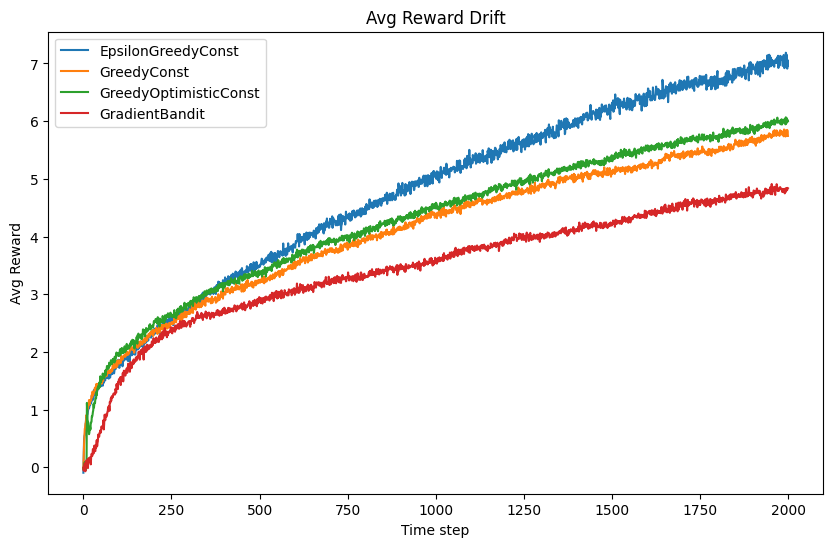

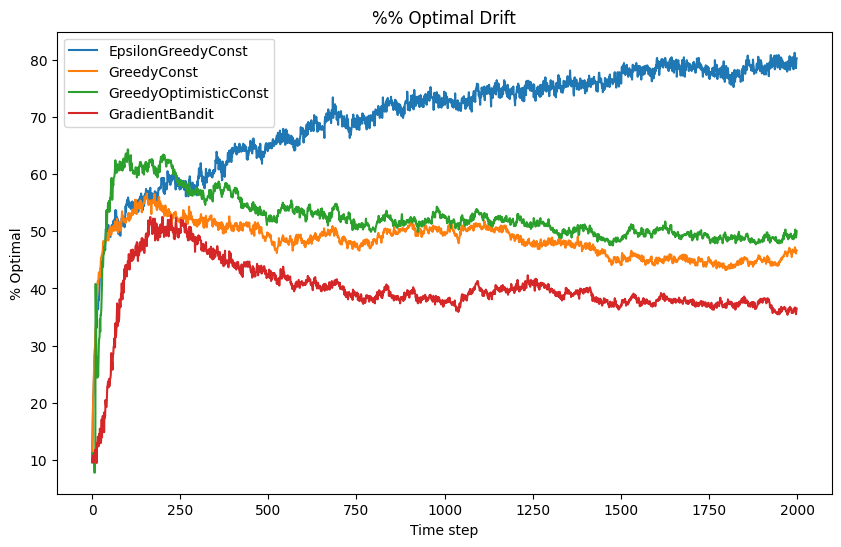

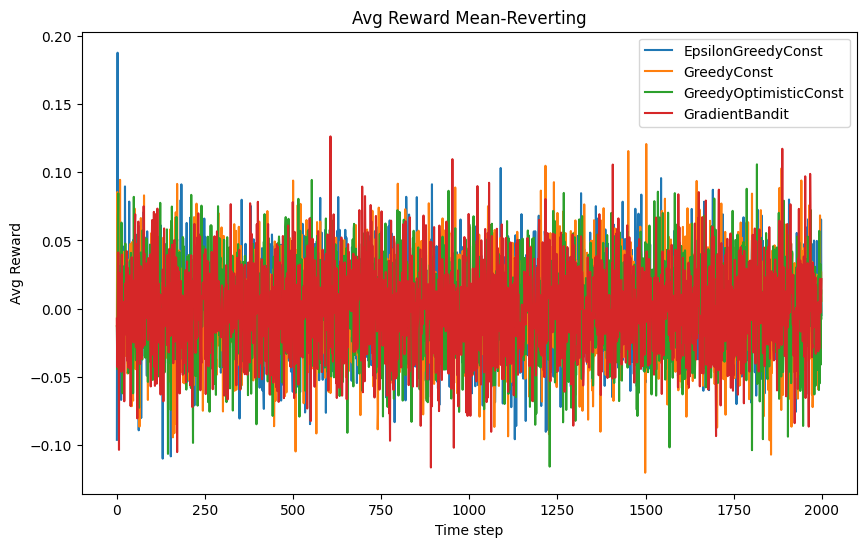

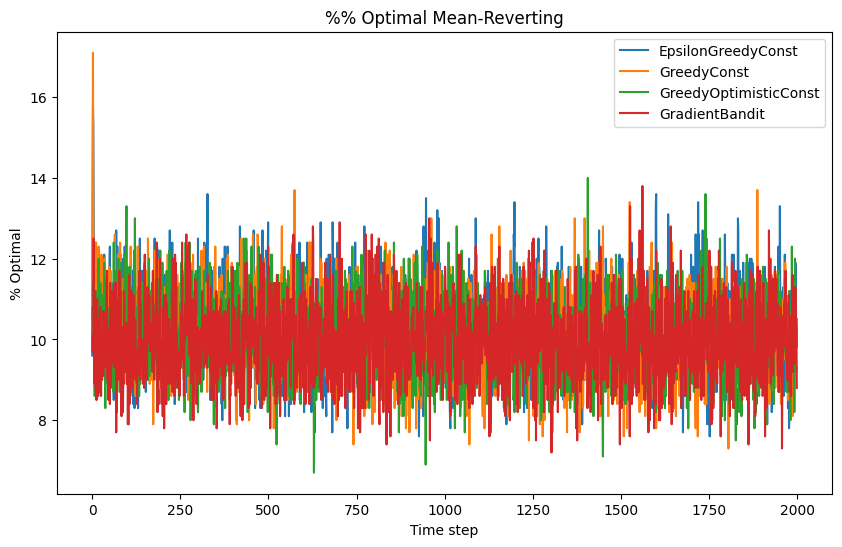

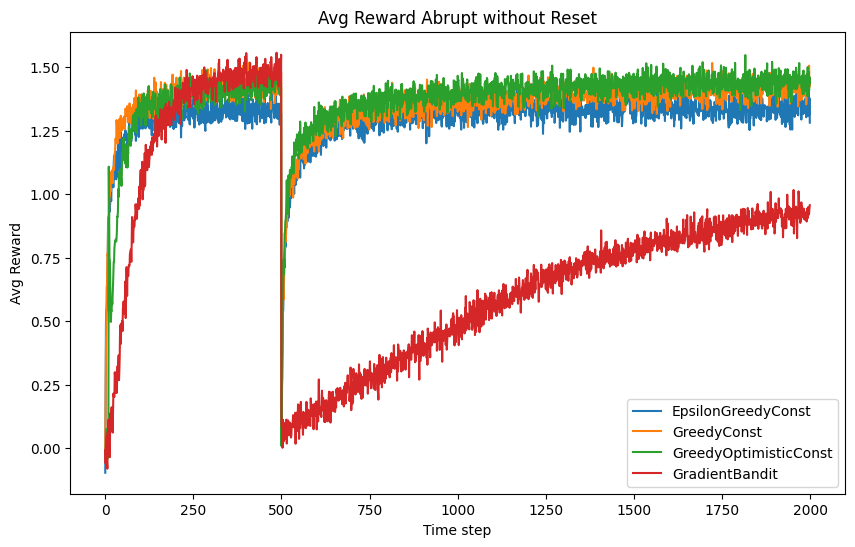

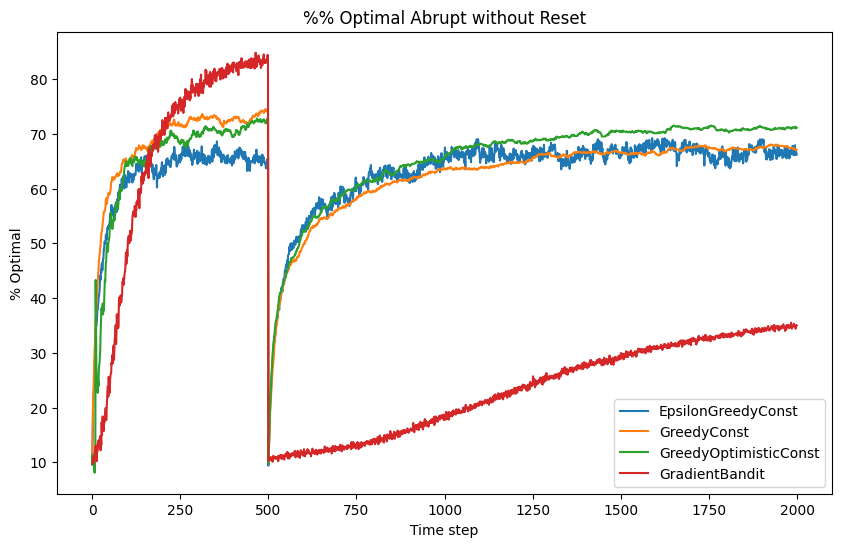

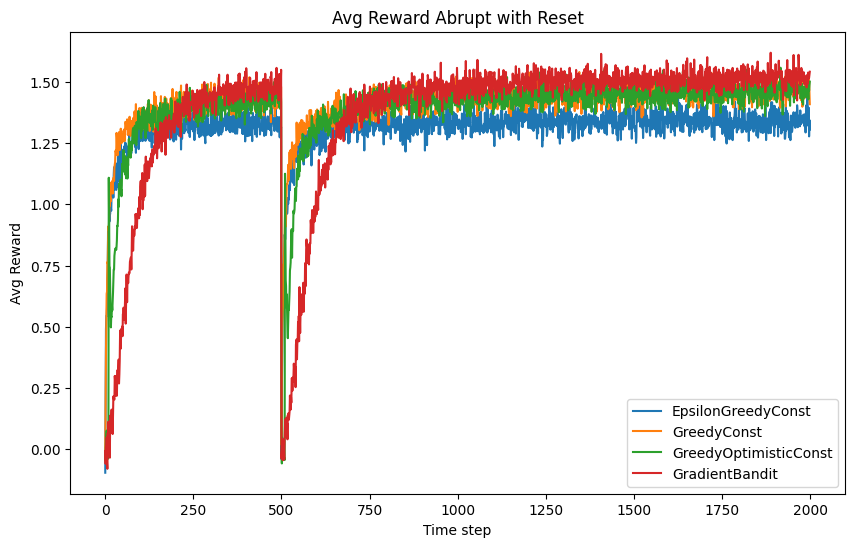

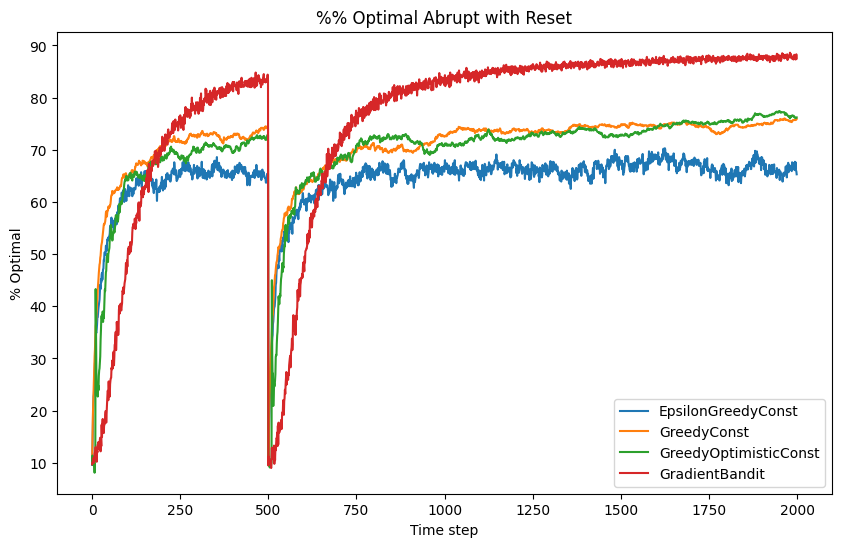

In [15]:
## Full Simulations (2000 steps × 1000 sims)


### Gradual: Drift

k = 10
time_steps = 2000
n_sims = 1000
# Use pilot-chosen best_epsilon, best_alpha_greedy, best_alpha_grad from pilot runs
agents_info = [
    ('EpsilonGreedyConst', EpsilonGreedyConstAgent, (best_epsilon, best_alpha_greedy)),
    ('GreedyConst', GreedyConstAgent, (best_alpha_greedy,)),
    ('GreedyOptimisticConst', GreedyOptimisticConstAgent, (best_alpha_greedy,)),
    ('GradientBandit', GradientBanditAgent, (best_alpha_grad,))
]
results_drift = {}
for name, cls, params in agents_info:
    avg_reward, pct_optimal = run_nonstationary_sim(cls, params, 'drift', k, time_steps, n_sims)
    results_drift[name] = (avg_reward, pct_optimal)
# Plotting drift results
plt.figure(figsize=(10,6))
for name, (avg_reward, _) in results_drift.items(): plt.plot(avg_reward, label=name)
plt.xlabel('Time step'); plt.ylabel('Avg Reward'); plt.title('Avg Reward Drift'); plt.legend(); plt.show()
plt.figure(figsize=(10,6))
for name, (_, pct_optimal) in results_drift.items(): plt.plot(pct_optimal, label=name)
plt.xlabel('Time step'); plt.ylabel('% Optimal'); plt.title('%% Optimal Drift'); plt.legend(); plt.show()


### Gradual: Mean-reverting

results_meanrev = {}
for name, cls, params in agents_info:
    avg_reward, pct_optimal = run_nonstationary_sim(cls, params, 'mean_reverting', k, time_steps, n_sims)
    results_meanrev[name] = (avg_reward, pct_optimal)
# Plotting mean-reverting results
plt.figure(figsize=(10,6))
for name, (avg_reward, _) in results_meanrev.items(): plt.plot(avg_reward, label=name)
plt.xlabel('Time step'); plt.ylabel('Avg Reward'); plt.title('Avg Reward Mean-Reverting'); plt.legend(); plt.show()
plt.figure(figsize=(10,6))
for name, (_, pct_optimal) in results_meanrev.items(): plt.plot(pct_optimal, label=name)
plt.xlabel('Time step'); plt.ylabel('% Optimal'); plt.title('%% Optimal Mean-Reverting'); plt.legend(); plt.show()


### Abrupt changes: without reset

results_abrupt_no_reset = {}
for name, cls, params in agents_info:
    avg_reward, pct_optimal = run_abrupt_sim(cls, params, k, time_steps, n_sims, reset_at_change=False)
    results_abrupt_no_reset[name] = (avg_reward, pct_optimal)
# Plotting
plt.figure(figsize=(10,6))
for name, (avg_reward, _) in results_abrupt_no_reset.items(): plt.plot(avg_reward, label=name)
plt.xlabel('Time step'); plt.ylabel('Avg Reward'); plt.title('Avg Reward Abrupt without Reset'); plt.legend(); plt.show()
plt.figure(figsize=(10,6))
for name, (_, pct_optimal) in results_abrupt_no_reset.items(): plt.plot(pct_optimal, label=name)
plt.xlabel('Time step'); plt.ylabel('% Optimal'); plt.title('%% Optimal Abrupt without Reset'); plt.legend(); plt.show()


### Abrupt changes: with reset at t=501

results_abrupt_reset = {}
for name, cls, params in agents_info:
    avg_reward, pct_optimal = run_abrupt_sim(cls, params, k, time_steps, n_sims, reset_at_change=True)
    results_abrupt_reset[name] = (avg_reward, pct_optimal)
# Plotting
plt.figure(figsize=(10,6))
for name, (avg_reward, _) in results_abrupt_reset.items(): plt.plot(avg_reward, label=name)
plt.xlabel('Time step'); plt.ylabel('Avg Reward'); plt.title('Avg Reward Abrupt with Reset'); plt.legend(); plt.show()
plt.figure(figsize=(10,6))
for name, (_, pct_optimal) in results_abrupt_reset.items(): plt.plot(pct_optimal, label=name)
plt.xlabel('Time step'); plt.ylabel('% Optimal'); plt.title('%% Optimal Abrupt with Reset'); plt.legend(); plt.show()



# Report: Reinforcement Learning Assignment 1

## 1. Introduction

This report covers both Part 1 (stationary 10-armed bandit) and Part 2 (non-stationary 10-armed bandit) experiments. We implemented from scratch four methods:

* **Greedy with non-optimistic initial values (0)**
* **Epsilon-greedy** (with pilot tuning for ε)
* **Greedy with optimistic initial values** (initial Q = μ\_max + 2.575)
* **Gradient bandit algorithm** (with pilot tuning for α)

In Part 1, the true means μ\_i are drawn once from N(0,1) and remain fixed. In Part 2, we consider:

1. **Gradual changes**:

   * **Drift**: μ\_{i,t} = μ\_{i,t−1} + ε\_{i,t}, ε ∼ N(0, 0.012)
   * **Mean-reverting**: μ\_{i,t} = 0.5·μ\_{i,t−1} + ε\_{i,t}, ε ∼ N(0, 0.012)
2. **Abrupt change**:

   * At t=501, permute the vector of μ\_i and continue.

For each scenario, we run:

* **Pilot runs** (short horizon, fewer sims) to tune ε and α.
* **Full simulation**: 2000 time steps × 1000 simulations, recording:

  * Average per-step reward (averaged over sims)
  * Percentage of optimal actions at each step

Tie-breaking among equal-valued actions is done uniformly at random (`np.random.choice`). Random seeds per simulation ensure reproducibility.

---

## 2. Methodology

### 2.1 Environment and Agent Implementations

* **Stationary environment** (Part 1):

  * For each simulation: sample true means μ\_i ∼ N(0,1) for i=1…10.
  * Reward for action a: R ∼ N(μ\_a, 1).
  * Optimal action(s): those with highest true mean.

* **Non-stationary environments** (Part 2):

  * **Drift**: generate a noise sequence ε\_{i,t} ∼ N(0, 0.012) for t=1…2000; set μ\_{i,0} ∼ N(0,1); then iterate μ\_{i,t} = μ\_{i,t−1} + ε\_{i,t}.
  * **Mean-reverting**: same noise but μ\_{i,t} = 0.5·μ\_{i,t−1} + ε\_{i,t}.
  * **Abrupt**: initial μ\_i ∼ N(0,1); stationary until t=500; at t=501 apply a fixed random permutation (same for all methods in that simulation) to the μ vector and remain fixed thereafter.

* **Agents**:

  * **GreedyZeroAgent**: Q initialized to 0; sample-average update in Part 1; replaced by constant-step update Q ← Q + α(R−Q) in Part 2.
  * **EpsilonGreedyAgent**: with parameter ε; sample-average or constant-step update.
  * **GreedyOptimisticAgent**: Q initialized to (μ\_max + 2.575); same update rules.
  * **GradientBanditAgent**: preferences H updated relative to baseline average reward; softmax action selection.

### 2.2 Pilot Tuning

* **Stationary (Part 1)**:

  * Epsilon candidates: \[0.01, 0.05, 0.1, 0.2].
  * Alpha candidates for gradient: \[0.1, 0.2, 0.5].
  * Short runs: e.g., 500 steps × 200 sims. Select ε and α yielding highest final average reward.
* **Non-stationary (Part 2)**:

  * Separate pilots for **drift** and **mean-reverting**:

    * Tune ε for ε-greedy constant-step.
    * Tune α for constant-step greedy and gradient bandit.
  * Short runs: e.g., 500 steps × 200 sims. Document chosen values.

### 2.3 Simulation Procedure

* **Full runs**: 2000 time steps × 1000 simulations for each method in each scenario.

* For each simulation:

  1. Set seed = simulation index (or with offset) for reproducibility.
  2. Sample initial μ\_i ∼ N(0,1).
  3. Initialize environment (stationary or non-stationary) with pre-generated noise/permutation.
  4. Instantiate agent with tuned parameters.
  5. For t in 1…2000:

     * (For abrupt with reset scenario) if t == 501 and reset flag is on, call `agent.reset()` before selecting.
     * Agent selects action via greedy/ε-greedy/softmax based on current Q or preferences.
     * Environment returns R\_t ∼ N(μ\_{a,t}, 1).
     * Agent updates its estimates or preferences.
     * Record R\_t and indicator if action was optimal at t.

* After all sims: compute

  * `avg_reward[t] = mean over sims of R_t`
  * `pct_optimal[t] = 100 * mean over sims of (action_t in optimal_actions at t)`

### 2.4 Plotting and Analysis

* For each method, plot:

  * **Average Reward vs. Time step** (0–1999)
  * **% Optimal Action vs. Time step**
* Combine methods on same plot for easy comparison.
* Refer to the corresponding code cells:

  * Part 1: “Full Simulation (2000 steps, 1000 simulations)” cells.
  * Part 2: separate sections for drift, mean-reverting, abrupt without reset, abrupt with reset.

---

## 3. Results Summary


### 3.1 Part 1 (Stationary)

* **GreedyZero**:

  * Quickly locks into the first arm that appears best early on; average reward plateaus at lower level; % optimal stabilizes at a low value (\~30–40%).
* **EpsilonGreedy**:

  * Initial exploration leads to discovering better arms; average reward rises more slowly but stabilizes higher; % optimal grows over time to a moderate value (\~70–80% depending on ε).
* **GreedyOptimistic**:

  * High initial Q encourages wide exploration early; quickly hones in on optimal arm; average reward increases rapidly; % optimal rises fast and settles around a high level (\~70%).
* **GradientBandit**:

  * Preferences updated relative to baseline allow gradual improvement; may start slower but often surpass epsilon-greedy in % optimal in later time steps; average reward curve similar or slightly above epsilon-greedy after convergence.

Plots (refer to Part 1 notebook demonstration and full-run plots) show:

* GreedyZero curve far below others.
* GreedyOptimistic and GradientBandit typically achieve the highest long-run average reward and % optimal.
* EpsilonGreedy in between.
* Discussion: optimistic initialization accelerates exploration in stationary; gradient bandit’s softmax updates adapt steadily.

### 3.2 Part 2 (Non-Stationary)

#### 3.2.1 Gradual Changes

* **Drift**:

  * True best arm can change slowly over time.
  * **GreedyConst (α)** without exploration fails to adapt when the best arm shifts.
  * **EpsilonGreedyConst (ε, α)**: exploration helps track slowly drifting optimum; average reward higher and % optimal closer to the drifting optimum than greedy.
  * **GreedyOptimisticConst**: optimistic init helps early, but after drift begins has no further exploration incentive unless reset; may fall behind ε-greedy.
  * **GradientBandit**: preference updates with constant α allow adaptation; performance often comparable to or better than ε-greedy depending on α; tracks drift effectively if α suitably chosen.
* **Mean-reverting**:

  * Means tend to revert toward zero; best arm may fluctuate but with tendency to centralize.
  * Constant-step updates enable forgetting outdated estimates.
  * Similar pattern: ε-greedy and gradient outperform greedy; optimistic only helps initially.
* Plots: refer to “Demo Avg Reward (drift/mean-reverting)” and full-run plots. Expect curves showing adaptation ability: methods with exploration/constant-step update maintain higher reward over time.

#### 3.2.2 Abrupt Changes

* At t=501, means are permuted; the previously optimal arm likely no longer optimal.
* **Without Reset**:

  * All agents experience sudden drop in average reward and % optimal at changepoint.
  * **GreedyConst**: no exploration → may never discover new optimum.
  * **EpsilonGreedyConst**: exploration allows gradual discovery of new best, recovery over time.
  * **GreedyOptimisticConst**: since Q retains outdated estimates, may persist on wrong arm; unless one re-applies optimistic re-initialization at changepoint, recovery slow.
  * **GradientBandit**: preference updates allow slow recovery; magnitude depends on α.
* **With Reset at t=501**:

  * Agent.reset() clears Q or preferences; loses prior knowledge but can relearn quickly.
  * **GreedyConst**: after reset, behaves as fresh greedy—needs exploration to find new optimum; without exploration fails; with optimistic re-init or ε-greedy needed.
  * **EpsilonGreedyConst**: reset + exploration yields faster recovery.
  * **GradientBandit**: reset preferences allows fresh tracking; recovery speed depends on α.
* Plots: refer to “Demo Avg Reward Abrupt” and full-run plots for both without and with reset. Compare area under curves pre- and post-change.

---

## 4. Discussion

* **Stationary vs. Non-Stationary**:

  * In stationary case, optimistic initialization and gradient bandit excel by quickly focusing on the true best arm.
  * In non-stationary, sample-average updates are insufficient; constant-step updates (α > 0) are needed to adapt.
  * Exploration (ε in ε-greedy) remains important in non-stationary to detect changes.
  * Gradient bandit method naturally incorporates a baseline and preference updates, offering a different adaptation mechanism; can perform comparably to ε-greedy constant-step.

* **Parameter Tuning**:

  * Stationary: smaller ε (e.g., 0.05) balances exploration/exploitation; α in gradient moderate (0.1–0.2).
  * Drift vs. Mean-Reverting: dynamics differ; pilot runs identify α large enough to forget old data but not too large to cause instability.
  * Abrupt: one might consider re-tuning or resetting parameters at changepoint; here we reset estimates but keep same α, ε.

* **Reset Strategy**:

  * Resetting at known changepoint yields faster post-change recovery but loses all prior learning value; in unknown environments, change detection methods would be needed.
  * For this assignment (with foreknowledge), reset demonstrates trade-offs.

* **Computational Considerations**:

  * Full runs (2000×1000 sims) are compute-intensive. Pilot/demonstration runs with fewer sims/time steps help choose parameters before full run.
  * Vectorization is limited since each simulation has its own evolving environment.

---

## 5. Conclusion

* **Part 1 (Stationary)**:

  * GreedyZero performs poorly.
  * GreedyOptimistic and GradientBandit achieve highest average reward and % optimal.
  * EpsilonGreedy is intermediate.

* **Part 2 (Non-Stationary)**:

  * Constant-step update is essential.
  * ε-greedy constant-step and GradientBandit adapt to drift and mean-reverting changes.
  * Greedy without exploration fails to track.
  * Abrupt changes cause performance drops; resetting estimates and using exploration/gradient updates enables recovery.

Overall, combining exploration and constant-step updates (or preference-based updates) is key in non-stationary settings, while optimistic initialization accelerates learning in stationary settings.

---

## 6. Reproducibility & Usage

1. **Dependencies**: Python 3.7+, `numpy`, `matplotlib`.
2. **Notebooks**:

   * Part 1 notebook defines stationary environment and agents, pilot tuning, demonstration, and full simulation code.
   * Part 2 notebook defines non-stationary environments, constant-step agents, pilot tuning, demonstration, and full simulation code.
3. **Procedure**:

   * Run pilot cells first to determine best ε and α values for each scenario.
   * Run full simulation cells (2000 steps × 1000 sims) locally.
   * Inspect plots inline.
   * All random seeds are set per simulation for reproducibility; adjust seed offsets if needed.
4. **Report Integration**:

   * In the notebook, refer to code cells by section headings (e.g., “Pilot runs for stationary”, “Simulation helper for non-stationary drift”) when discussing results.

---

## 6. References to Code/Plots

* **Part 1 Code Cells**:

  * Environment & Agent definitions (stationary).
  * `run_simulation` helper.
  * Pilot tuning cell for ε and α.
  * Demonstration run cell with reduced settings.
  * Full simulation cell.
  * Plots: “Average Reward over Time” and “% Optimal Action over Time”.

* **Part 2 Code Cells**:

  * `NonStationaryBandit` and `AbruptBandit` environment classes.
  * Constant-step agent classes and GradientBanditAgent.
  * `run_nonstationary_sim` and `run_abrupt_sim` helpers.
  * Pilot tuning for drift/mean-reverting.
  * Demonstration run cells: drift/mean-reverting and abrupt (with/without reset).
  * Full simulation cells.
  * Plots: “Demo Avg Reward (drift/mean-reverting)”, “Demo % Optimal …”, and full-run plots.

When interpreting plots:

* Identify curves by legend entries matching agent names.
* Note changepoint at t=500 in abrupt plots—observe drop and recovery patterns.
* Compare long-run plateaus in stationary vs. tracking behavior in non-stationary.

---


